## Modeling for predicting critical outcome at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers6 import PlotROCCurve
from dataset_path import output_path

path = output_path

df_train = pd.read_csv((os.path.join(path, 'train2.csv')))
df_test = pd.read_csv((os.path.join(path, 'test2.csv')))
confidence_interval = 95
random_seed = 0

In [2]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

df_train.head()

,subject_id,hadm_id,stay_id,intime_ed,outtime_ed,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,race,race_recoded,edregtime,edouttime,insurance,in_year,age,age_derived,before_ed_mortality,outcome_hospitalization,outcome_inhospital_mortality,intime_icu,outtime_icu,outcome_icu_transfer_12h,outcome_critical,outcome_ed_revisit_3d,triage_temperature,triage_temperature_recoded_2,triage_heartrate,triage_heartrate_recoded,triage_resprate,triage_resprate_recoded,triage_o2sat,triage_o2sat_recoded,triage_sbp,triage_sbp_recoded,triage_dbp,triage_dbp_recoded,hos_los,ed_los,triage_pain,triage_pain_recoded,triage_acuity,chiefcomplaint,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,...,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_temperature_last_recoded,ed_heartrate_last,ed_heartrate_last_recoded,ed_resprate_last,ed_resprate_last_recoded,ed_o2sat_last,ed_o2sat_last_recoded,ed_sbp_last,ed_sbp_last_recoded,ed_dbp_last,ed_dbp_last_recoded,ed_pain_last,ed_pain_last_recoded,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,18971123,21753872.0,37200982,15/7/2149 22:41,16/7/2149 6:27,45.0,F,2149.0,NaN,16/7/2149 4:10,28/7/2149 18:37,NaN,WHITE,WHITE,15/7/2149 22:41,16/7/2149 6:27,Other,2149,45.0,0,False,True,False,NaN,NaN,False,False,False,37.444444,37.444444,102.0,102.0,19.0,19.0,100.0,100.0,133.0,133.0,88.0,88.0,302.0,8,0.0,0.0,2.0,Hypokalemia,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.333333,36.333333,72.0,72.0,16.0,16.0,100.0,100.0,165.0,165.0,105.0,105.0,0.0,0.0,3,1,103.000000,0,0,2,1,1,2
1,15439233,NaN,31867345,20/12/2159 19:43,20/12/2159 19:59,18.0,M,2159.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2159,18.0,0,False,False,False,NaN,NaN,False,False,False,37.111111,37.111111,70.0,70.0,20.0,20.0,99.0,99.0,151.0,151.0,64.0,64.0,NaN,0,7.0,7.0,3.0,MVC,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.666667,36.666667,60.0,60.0,16.0,16.0,100.0,100.0,132.0,132.0,70.0,70.0,7.0,7.0,1,0,93.000000,0,0,0,0,0,1
2,15341533,NaN,30037900,2/9/2171 21:24,2/9/2171 21:27,40.0,F,2171.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2171,40.0,0,False,False,False,NaN,NaN,False,False,False,37.555556,37.555556,97.0,97.0,16.0,16.0,97.0,97.0,120.0,120.0,70.0,70.0,NaN,0,0.0,0.0,5.0,Med refill,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.555556,37.555556,95.0,95.0,18.0,18.0,98.0,98.0,113.0,113.0,67.0,67.0,0.0,0.0,0,0,86.666667,0,0,0,1,1,1
3,13512582,NaN,38777853,8/11/2131 22:59,8/11/2131 23:04,70.0,F,2131.0,NaN,NaN,NaN,NaN,HISPANIC/LATINO - PUERTO RICAN,HISPANIC,NaN,NaN,NaN,2131,70.0,3,False,False,False,NaN,NaN,False,False,False,37.000000,37.000000,58.0,58.0,16.0,16.0,100.0,100.0,155.0,155.0,44.0,44.0,NaN,1,10.0,10.0,3.0,ABD PAIN,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.111111,37.111111,51.0,51.0,18.0,18.0,96.0,96.0,173.0,173.0,63.0,63.0,2.0,2.0,3,2,81.000000,3,13,7,0,0,1
4,17758321,NaN,35942414,25/6/2115 13:15,25/6/2115 13:38,50.0,M,2115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2115,50.0,1,False,False,False,NaN,NaN,False,False,False,36.555556,36.555556,72.0,72.0,16.0,16.0,96.0,96.0,187.0,187.0,108.0,108.0,NaN,0,6.0,6.0,5.0,MEDICATION REFILL,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.777778,36.777778,62.0,62.0,16.0,16.0,100.0,100.0,161.0,161.0,99.0,99.0,0.0,2.0,1,2,134.333333,1,0,5,0,0,1


### 1. task-specific filter

In [3]:
#df_train = df_train[df_train['ed_death'] == False]
#df_test = df_test[df_test['ed_death'] == False].reset_index()

### 2. Variable Selection

In [4]:
variable = ["age", "gender", "race_recoded",
            
            "triage_temperature_recoded_2", "triage_heartrate_recoded", "triage_resprate_recoded", 
            "triage_o2sat_recoded", "triage_sbp_recoded", "triage_dbp_recoded",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV"]

outcome = "outcome_critical"

In [5]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [6]:
X_train.dtypes.to_frame().T

,age,gender,race_recoded,triage_temperature_recoded_2,triage_heartrate_recoded,triage_resprate_recoded,triage_o2sat_recoded,triage_sbp_recoded,triage_dbp_recoded,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV
0,float64,object,object,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [7]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [8]:
X_train['race_recoded'] = encoder.fit_transform(X_train['race_recoded'])
X_test['race_recoded'] = encoder.transform(X_test['race_recoded'])

In [9]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.06275655051445725 : 1


### 3.  Modeling script

In [10]:
# Containers for all results
result_list = []

Logistic Regression:


C:\Users\prach\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 4.545889377593994 seconds
AUC: 0.7701946378194982
AUPRC: 0.22248693638917488
Sensitivity: 0.7013549115543847
Specificity: 0.6994193836534167
Score thresold: 0.0581644174199818
2.5 97.5


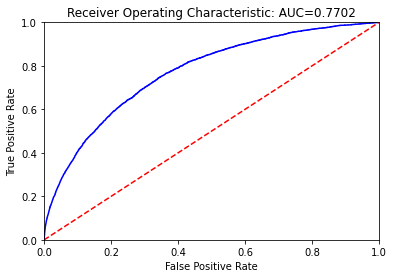

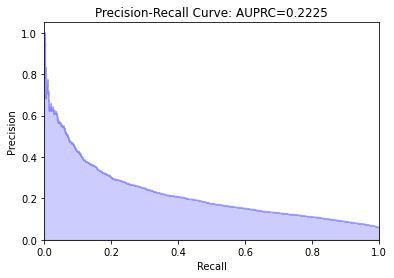

In [11]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

RandomForest:
Training time: 35.04786705970764 seconds
AUC: 0.8550372938593491
AUPRC: 0.36757188849321665
Sensitivity: 0.776815957847196
Specificity: 0.7454462054730031
Score thresold: 0.062
2.5 97.5


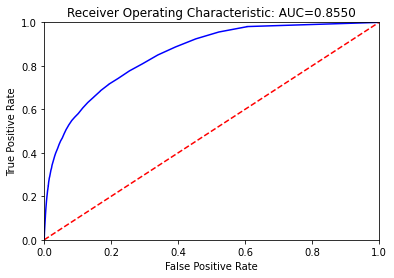

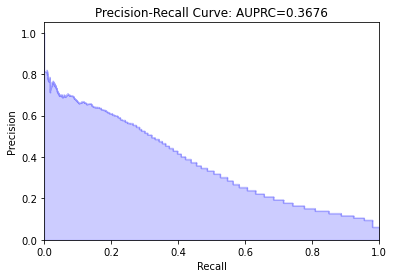

[0.13181199 0.01683175 0.06334741 0.11015333 0.14199813 0.07468469
 0.06863456 0.14507805 0.11936649 0.00867152 0.00938993 0.00838815
 0.00892623 0.00471868 0.01280812 0.00490005 0.0051602  0.008655
 0.01185754 0.00815353 0.00432554 0.00995673 0.00949125 0.0048782
 0.00565754 0.0021554 ]


In [12]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 37.15438723564148 seconds
AUC: 0.8641659299759378
AUPRC: 0.38698965791312673
Sensitivity: 0.7572450131727512
Specificity: 0.7746098040872493
Score thresold: 0.06349187520131705
2.5 97.5


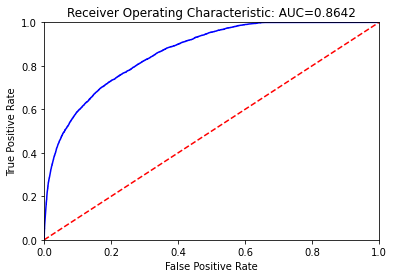

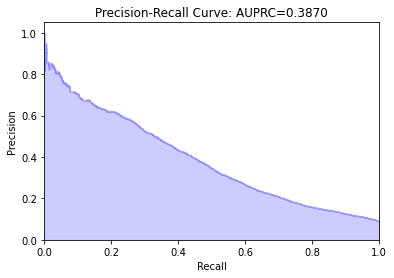

In [13]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [14]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [15]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('critical_triage_mlp')

Epoch 1/20
1764/1764 [==============================] - 4s 1ms/step - loss: 0.2369 - accuracy: 0.9390 - auc: 0.7333 - auprc: 0.1810 - true_positives: 1278.0000 - true_negatives: 329858.0000 - precision: 0.3962 - recall: 0.0614
Epoch 2/20
1764/1764 [==============================] - 2s 1ms/step - loss: 0.1996 - accuracy: 0.9409 - auc: 0.7561 - auprc: 0.2070 - true_positives: 1189.0000 - true_negatives: 330596.0000 - precision: 0.4956 - recall: 0.0571
Epoch 3/20
1764/1764 [==============================] - 3s 2ms/step - loss: 0.1952 - accuracy: 0.9412 - auc: 0.7697 - auprc: 0.2217 - true_positives: 1101.0000 - true_negatives: 330804.0000 - precision: 0.5235 - recall: 0.0529
Epoch 4/20
1764/1764 [==============================] - 3s 2ms/step - loss: 0.1926 - accuracy: 0.9413 - auc: 0.7787 - auprc: 0.2289 - true_positives: 1022.0000 - true_negatives: 330917.0000 - precision: 0.5348 - recall: 0.0491
Epoch 5/20
1764/1764 [==============================] - 2s 1ms/step - loss: 0.1892 - accurac

MLP:
2755/2755 [==============================] - 2s 776us/step
AUC: 0.8456987004875036
AUPRC: 0.29667113077687035
Sensitivity: 0.7743695897628905
Specificity: 0.7350530521589029
Score thresold: 0.053279977
2.5 97.5


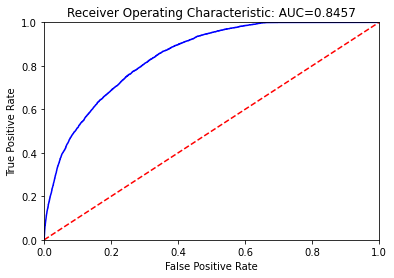

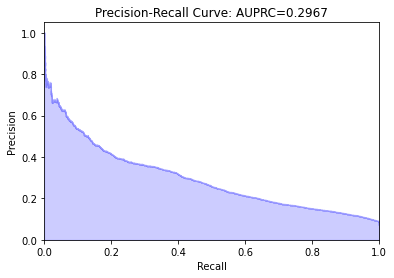

In [16]:
print("MLP:")
mlp = load_model('critical_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [17]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


score_NEWS
AUC: 0.6376764336379722
AUPRC: 0.16232514515864588
Sensitivity: 0.4708317651486639
Specificity: 0.7928732662989028
Score thresold: 2
2.5 97.5


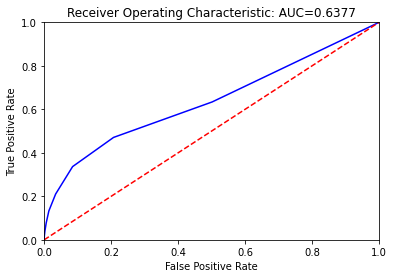

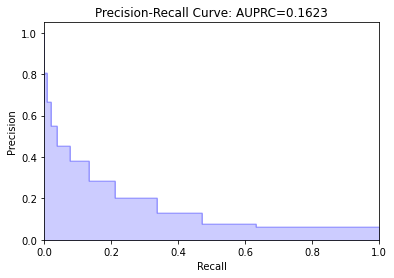

In [18]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.6227714867884439
AUPRC: 0.14694447267184985
Sensitivity: 0.4213398569815581
Specificity: 0.8208418333474162
Score thresold: 2
2.5 97.5


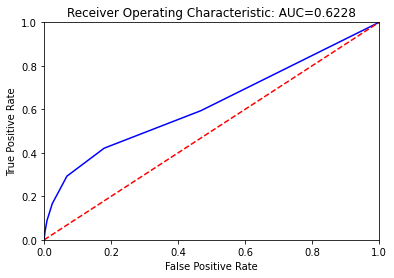

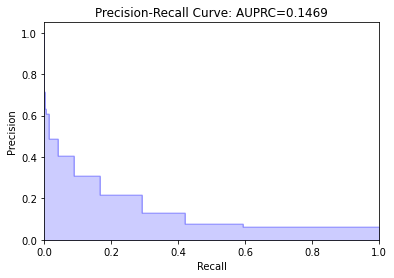

In [19]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6884323183732768
AUPRC: 0.111151890501994
Sensitivity: 0.682913059841927
Specificity: 0.612809772702582
Score thresold: 5
2.5 97.5


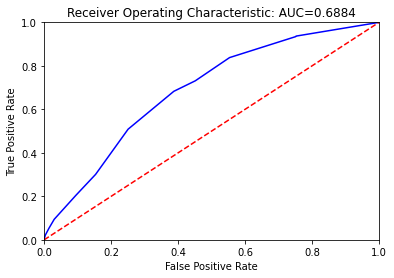

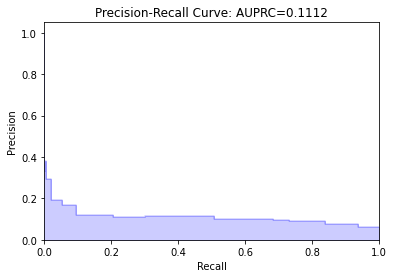

In [20]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.6212346128095318
AUPRC: 0.11722823112263829
Sensitivity: 0.44617990214527664
Specificity: 0.7705177263015583
Score thresold: 2
2.5 97.5


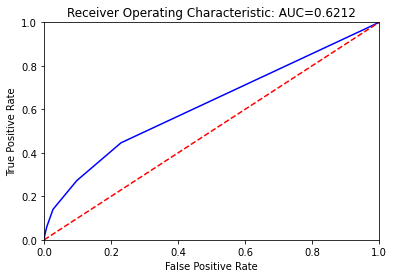

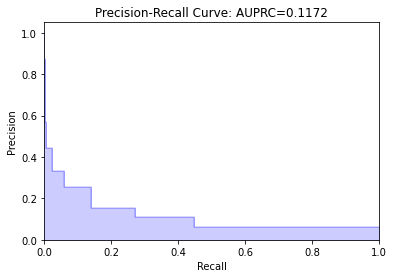

In [21]:
get_score_performance("score_MEWS", random_seed=random_seed)

### 4. Performance output

In [22]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                               'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                               'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 
                                               'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_triage.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task2.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.058,0.77 (0.763-0.776),0.222 (0.214-0.23),0.701 (0.686-0.731),0.699 (0.681-0.709),4.546
1,RF,0.062,0.855 (0.851-0.858),0.368 (0.353-0.381),0.777 (0.729-0.783),0.745 (0.743-0.794),35.048
2,GB,0.063,0.864 (0.861-0.869),0.387 (0.377-0.4),0.757 (0.745-0.775),0.775 (0.764-0.788),37.154
3,MLP,0.053,0.846 (0.843-0.85),0.297 (0.282-0.308),0.774 (0.755-0.783),0.735 (0.732-0.755),45.505
4,score_NEWS,2.000,0.638 (0.629-0.645),0.162 (0.154-0.169),0.471 (0.458-0.482),0.793 (0.791-0.796),0.000
5,score_NEWS2,2.000,0.623 (0.615-0.631),0.147 (0.14-0.153),0.421 (0.409-0.434),0.821 (0.819-0.824),0.000
6,score_REMS,5.000,0.688 (0.683-0.693),0.111 (0.108-0.114),0.683 (0.676-0.693),0.613 (0.61-0.616),0.000
7,score_MEWS,2.000,0.621 (0.615-0.628),0.117 (0.112-0.122),0.446 (0.434-0.459),0.771 (0.768-0.773),0.000


In [23]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
7,triage_sbp_recoded,0.145078
4,triage_heartrate_recoded,0.141998
0,age,0.131812
8,triage_dbp_recoded,0.119366
3,triage_temperature_recoded_2,0.110153
5,triage_resprate_recoded,0.074685
6,triage_o2sat_recoded,0.068635
2,race_recoded,0.063347
1,gender,0.016832
14,cci_Pulmonary,0.012808
